# Scaling and Efficiency

In [ ]:
# Defaults
strong_scaling_book_path = '../runs/strong_scaling'
weak_scaling_book_path = '../runs/weak_scaling'

In [1]:
import scrapbook as sb
import matplotlib.pyplot as plt
import mhpc_project.plots as plots

In [2]:
strong_scaling_book = sb.read_notebooks('strong_scaling')

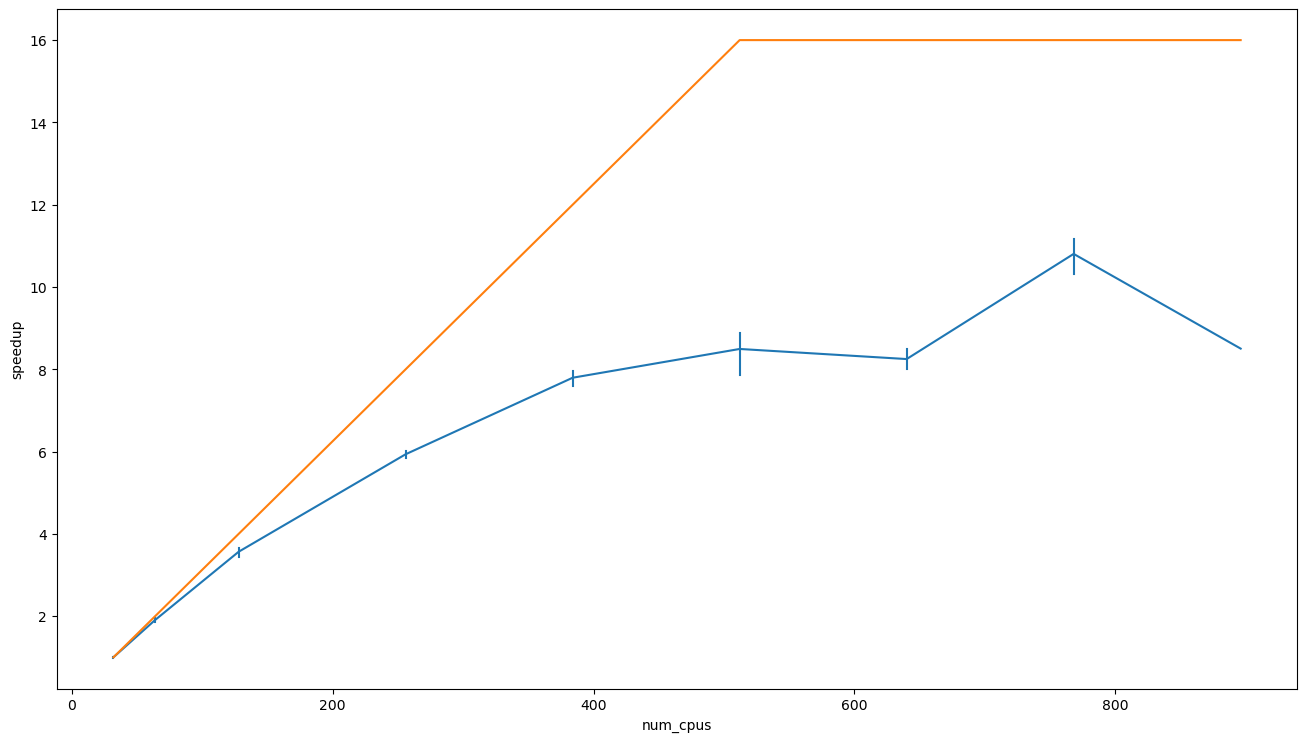

In [3]:
plots.strong_scaling(strong_scaling_book)
plt.show()

In [ ]:
plots.efficiency(strong_scaling_book)
plt.show()

In [ ]:
weak_scaling_book = sb.read_notebooks('weak_scaling')

In [4]:
plots.weak_scaling(weak_scaling_book)
plt.show()


AttributeError: module 'mhpc_project.plots' has no attribute 'scaling'

In [ ]:
plots.efficiency(weak_scaling_book)
plt.show()